In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pandas as pd


plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
#os.chdir('/Users/lynnsorensen/surfdrive/Arousal_asn_export')

In [11]:
# Figure S3 - importance curves
tracker = joblib.load('Results/tracker_spatialJumble.pkl')

rates = np.append(0, tracker['rates'])
places = tracker['places']

num_rands = [1.125, 1.25, 1.5,2, 3, 4, 5,6, 8, 10, 20, 30, 40]

num_rands = list(reversed(num_rands))
colors = sns.color_palette('magma', len(num_rands))

sns.set_context('poster')

df = pd.DataFrame({'Layer':[],
                   'Block':[],
                   'Num_rand':[],
                   'Rate':[],
                   'Iteration':[],
                   'Binary Accuracy':[]})

c = 0
for p,l in enumerate(places):
    for n, num_rand in enumerate([1.25, 3, 20]):
        tag = 'random' + str(num_rand)
        for i, r in enumerate(rates):
            for iter in range(tracker['iterations']):
                df.loc[c, 'Layer'] = l
                df.loc[c, 'Block'] = p + 1
                df.loc[c, 'Rate'] = r
                df.loc[c, 'Num_rand'] = num_rand
                df.loc[c, 'Iteration'] = iter
                if r == 0:
                    df.loc[c, 'Binary Accuracy'] = tracker['random' + str(num_rand)]['training_0']['baseline'][1]
                else:
                    df.loc[c, 'Binary Accuracy'] = tracker['random' + str(num_rand)]['training_0'][l][i-1, iter, 1]
                c = c + 1



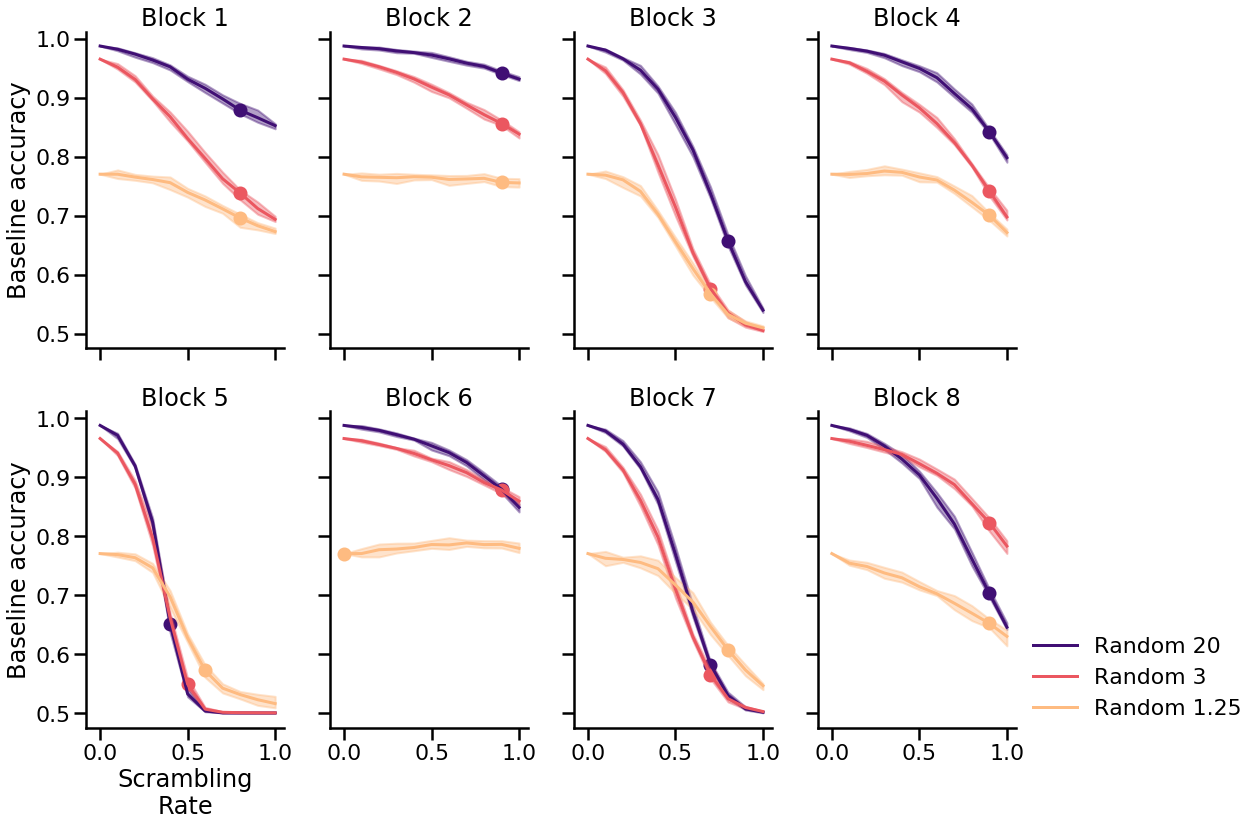

In [12]:
f, ax = plt.subplots(2, 4, figsize=(18, 12), sharey=True, sharex=True)
ax = ax.flatten()
for b in range(len(places)):
    for n, num_rand in enumerate(num_rands):
        if num_rand in [1.25, 3, 20]:
            scores = np.concatenate([np.ones((1, tracker['iterations'], 2)) * tracker['random' + str(num_rand)]['training_0']['baseline'],
                                    tracker['random' + str(num_rand)]['training_0'][places[b]]], axis=0)

            ax[b].plot(rates, np.mean(scores[:, :, 1], axis=1),  color=colors[n],label='Random ' + str(num_rand))
            ax[b].fill_between(rates, np.percentile(scores[:, :, 1], 97.5, axis=1),
                               np.percentile(scores[:, :, 1], 2.5, axis=1), color=colors[n],
                               alpha = 0.4)

            target_rate = 0.2
            if np.mean(scores[:, :, 1] , axis=1)[-1] < np.mean(scores[:, :, 1] , axis=1)[0]:

                tmp = abs((np.mean(scores[:, :, 1], axis=1) - np.mean(scores[:, :, 1] , axis=1)[-1])/ (tracker['random' + str(num_rand)]['training_0']['baseline'][1] - np.mean(scores[:, :, 1] , axis=1)[-1]) - target_rate)

                ax[b].scatter(rates[np.min(tmp) == tmp][0], np.mean(scores[:, :, 1], axis=1)[np.min(tmp) == tmp][0],
                              color=colors[n])
                
            else:
                ax[b].scatter(rates[0], np.mean(scores[:, :, 1] , axis=1)[0],
                              color=colors[n])

        sns.despine()
        ax[b].set_title('Block ' + str(b+1))

plt.legend(frameon=False, loc=(1.04, 0))
ax[4].set_xlabel('Scrambling\nRate')

ax[0].set_ylabel('Baseline accuracy')
ax[4].set_ylabel('Baseline accuracy')
plt.tight_layout()

plt.show()

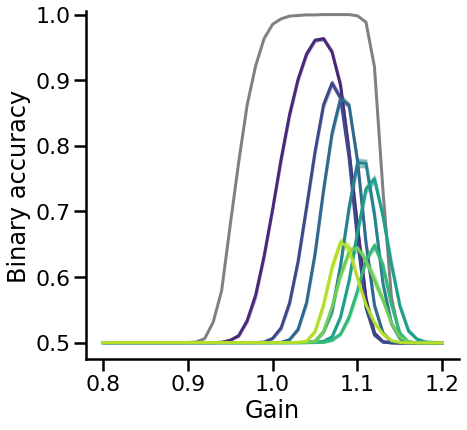

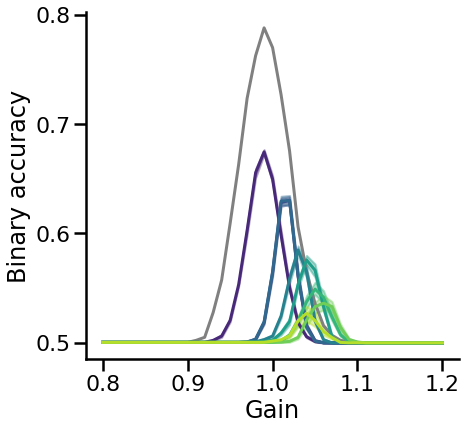

In [4]:
# FIGURE 5B
for num_rand in [20, 1.25]:
    fig, ax = plt.subplots(1, figsize=(7, 6.5))
    ax.plot(tracker_baseline['gains'][gains_baseline], tracker_baseline['random' + str(num_rand)]['Training-0']['Test']['binaryAcc'][gains_baseline], color='gray', label='baseline')
    sns.lineplot(data=df[df['Num_rand'] == num_rand], x='Gain', y='Binary Accuracy', palette=sns.color_palette('viridis', len(places)),
                      hue='Layer', hue_order=places,
                      legend=False, err_kws={'alpha': 0.4}, ax=ax)

    sns.despine()
    if num_rand == 1.25:
        plt.yticks([0.5, 0.6, 0.7, 0.8])
    if num_rand == 20:
        ylims =plt.gca().get_ylim()
        plt.ylim([ylims[0], 1.005])
    plt.xlabel('Gain')
    plt.ylabel('Binary accuracy')
    plt.tight_layout()
    plt.show()

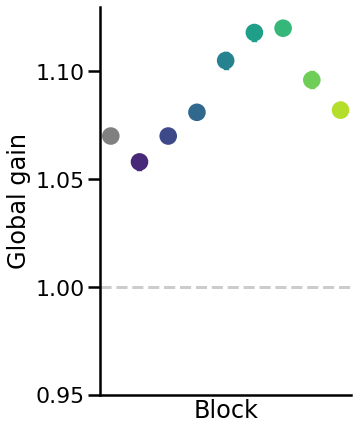

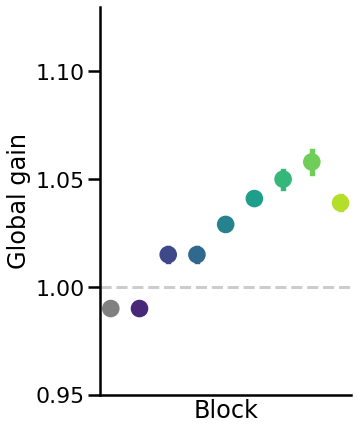

In [5]:
# FIGURE 5C
colors_scatter = np.vstack([(0.5, 0.5, 0.5), sns.color_palette('viridis', len(places))])
for num_rand in [20, 1.25]:#, 1.25]:

    max_gain = [gains[int(np.median(np.where(
        tracker_baseline['random' + str(num_rand)]['Training-0']['Test']['binaryAcc'][gains_baseline] ==
        tracker_baseline['random' + str(num_rand)]['Training-0']['Test']['binaryAcc'][gains_baseline].max())[0]))]]

    cond = ['baseline']
    
    for b in range(len(places)):
        scores = tracker['random' + str(num_rand)]['training_0'][places[b]]
        for i in range(tracker['iterations']):
            max_gain.append(gains[int(np.median(np.where(scores[:, i, 1] == scores[:, i, 1].max())[0]))])
            cond.append(places[b])

    plt.figure(figsize=(5.5, 6.5))
    ax = sns.pointplot(x=cond, y=max_gain, hue=cond, palette=colors_scatter, join=False,
                       dodge=True,
                       legend=False)

    ax.get_legend().remove()
    ax.axhline(1, c='gray', alpha=0.4, ls='--')
    ax.set_ylim([0.95, 1.13])
    ax.set_yticks([0.95, 1, 1.05, 1.1])
    
    ax.set_xticks([])
    ax.set_ylabel('Global gain')
    ax.set_xlabel('Block')
    sns.despine()
    plt.tight_layout()

    plt.show()

In [6]:
# Same but now from early to late!
tracker = joblib.load('Results/tracker_spatialJumbleGain_allBlocks_0.2_reversed.pkl')
places = tracker['places']

gains = tracker['gains']

tracker_baseline = joblib.load('Results/tracker_BinaryEvolvingTask.pkl')

sns.set_context('poster')

gains_baseline = [g for g in range(len(tracker_baseline['gains'])) if tracker_baseline['gains'][g] in gains]

df = pd.DataFrame({'Layer': [],
                   'Block': [],
                   'Num_rand': [],
                   'Gain': [],
                    'Iteration': [],
                   'Binary Accuracy': []})
c = 0
for num_rand in [20, 1.25]:
    for p, l in enumerate(places):
        for i, g in enumerate(tracker['gains']):
            for iter in range(tracker['iterations']):
                df.loc[c, 'Layer'] = l
                df.loc[c, 'Block'] = p + 1
                df.loc[c, 'Gain'] = g
                df.loc[c, 'Num_rand'] = num_rand
                df.loc[c, 'Iteration']= iter
                df.loc[c, 'Binary Accuracy'] = tracker['random' + str(num_rand)]['training_0'][l][i, iter, 1]
                c = c + 1


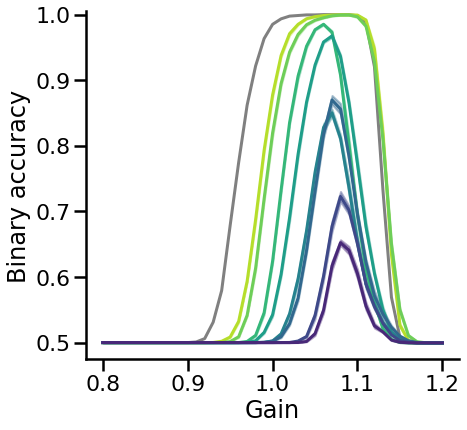

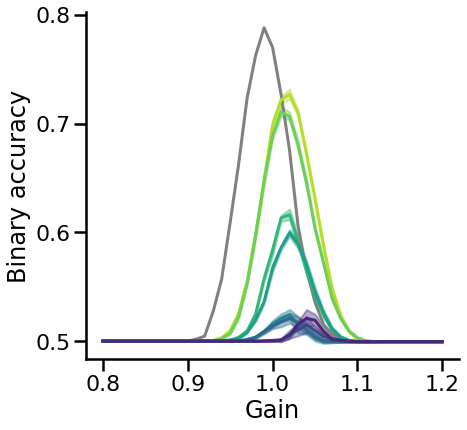

In [7]:
# FIGURE S4

for num_rand in [20, 1.25]:
    fig, ax = plt.subplots(1, figsize=(7, 6.5))
    ax.plot(tracker_baseline['gains'][gains_baseline], tracker_baseline['random' + str(num_rand)]['Training-0']['Test']['binaryAcc'][gains_baseline], color='gray', label='baseline')
    sns.lineplot(data=df[df['Num_rand'] == num_rand], x='Gain', y='Binary Accuracy', palette=sns.color_palette('viridis_r', len(places)),
                      hue='Layer', hue_order=places,
                      legend=False, err_kws={'alpha': 0.4}, ax=ax)#, linewidth=5)

    sns.despine()
    if num_rand == 1.25:
        plt.yticks([0.5, 0.6, 0.7, 0.8])
    if num_rand == 20:
        ylims =plt.gca().get_ylim()
        plt.ylim([ylims[0], 1.005])
    plt.xlabel('Gain')
    plt.ylabel('Binary accuracy')
    plt.tight_layout()

    plt.show()

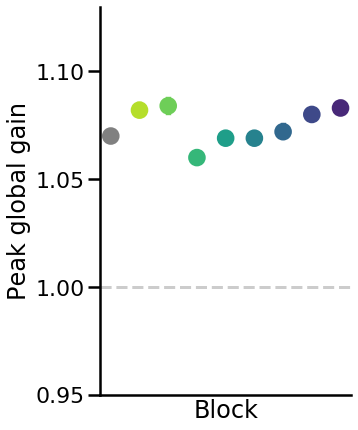

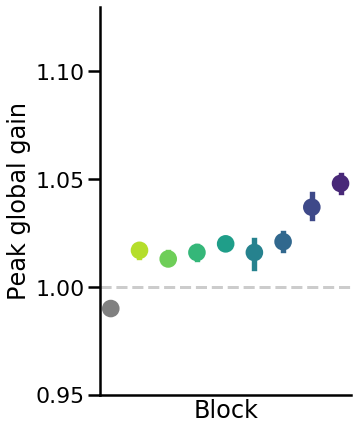

In [8]:
# FIGURE 5D

colors_scatter = np.vstack([(0.5, 0.5, 0.5), sns.color_palette('viridis_r', len(places))])
for num_rand in [20, 1.25]:#, 1.25]:

    max_gain = [gains[int(np.median(np.where(
        tracker_baseline['random' + str(num_rand)]['Training-0']['Test']['binaryAcc'][gains_baseline] ==
        tracker_baseline['random' + str(num_rand)]['Training-0']['Test']['binaryAcc'][gains_baseline].max())[0]))]]

    cond = ['baseline']

    for b in range(len(places)):
        scores = tracker['random' + str(num_rand)]['training_0'][places[b]]
        for i in range(tracker['iterations']):
            max_gain.append(gains[int(np.median(np.where(scores[:, i, 1] == scores[:, i, 1].max())[0]))])
            cond.append(places[b])

    plt.figure(figsize=(5.5, 6.5))
    ax = sns.pointplot(x=cond, y=max_gain, hue=cond, palette=colors_scatter, join=False,
                       dodge=True,
                       legend=False)

    ax.get_legend().remove()
    ax.axhline(1, c='gray', alpha=0.4, ls='--')
    ax.set_ylim([0.95, 1.13])
    ax.set_yticks([0.95, 1, 1.05, 1.1])
    ax.set_xticks([])
    ax.set_ylabel('Peak global gain')
    ax.set_xlabel('Block')
    sns.despine()
    plt.tight_layout()
    plt.show()